In [1]:
import numpy as np
from numpy.linalg import norm
import scipy as sc
import pandas as pd
import math
import random
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock, correlation, chebyshev, cosine
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from itertools import product
from sklearn.svm import SVC #todo
from scipy.spatial.distance import euclidean, cityblock, correlation, chebyshev, cosine

%matplotlib inline

In [2]:
data = pd.read_table('chips.txt', header=None, sep = ',')
classes = data[2]
features = data.drop(data.columns[[2]], axis=1)
data.head()

X = features.as_matrix()
Y = classes.as_matrix()

In [3]:
gauss_K = lambda r : np.exp(-2 * r ** 2)
square_K = lambda r : 0 if r > 1 else (1 - r ** 2)
triangle_K = lambda r : 0 if r > 1 else (1 - np.abs(r))

In [4]:
def get_f1_score(y_true, y_pred):
    combined = [ [a,b] for (a,b) in zip(y_true, y_pred) ]
    tp = sum(x[0] == 1 and x[1] == 1 for x in combined) 
    tn = sum(x[0] != 1 and x[1] != 1 for x in combined) 
    fp = sum(x[0] != 1 and x[1] == 1 for x in combined) 
    fn = sum(x[0] == 1 and x[1] != 1 for x in combined) 
    if tp == 0:
        return 0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

In [5]:
def kNN(k, metrics, trainX, trainY, testX, K=None):
    result = []
    i = 0
    for point in testX:
        distances = [[trainY[i], metrics(point, trainX[i])] for i in range (0, len(trainY))]
        distances.sort(key=lambda p:p[1])

        stat = [0., 0.]
        if K is None:
            for d in distances[0 : k]:
                stat[int(d[0])] += 1
        else:
            w = lambda d : K(d / distances[k+1][1])
            for d in distances:
                stat[int(d[0])] += w(d[1])
            
        prediction = -1
        if (stat[0] > stat[1]):
            prediction = 0
        else:
            prediction = 1
        result.append(prediction)
    return result

In [6]:
class SVM_Classifier:
    def __init__(self, C = 1.0, K=None):
        self.C = C
        
        if K is None:
            print('Using default kernel')
            K = lambda u, v : np.dot(u.T, v)
        self.K = K
    
    
    def kV(self, x, dataX):
        return np.apply_along_axis(lambda c : self.K(x, c), 1, dataX)

    
    def __optimization_fun__(self, alpha):
        products = np.apply_along_axis(lambda c : c * alpha, 1, self.products)
        products = np.apply_along_axis(lambda c : c * alpha, 0, products)
        return -np.sum(alpha) + 0.5 * np.sum(products)
        
    def __cons_fun__(self, alpha):
        return np.sum(self.trainY * alpha)
    
    def fit(self, trainX, trainY):
        self.trainX = np.array(trainX)
        self.trainY = np.array(trainY) * 2 - 1
        
        self.products = np.apply_along_axis(lambda c : self.kV(c, self.trainX), 1, self.trainX)
        self.products = np.apply_along_axis(lambda c : c * self.trainY, 1, self.products)
        self.products = np.apply_along_axis(lambda c : c * self.trainY, 0, self.products)
        
        XX = self.K(self.trainX[:,np.newaxis,...], self.trainX[np.newaxis,...])
        B = self.trainY[:,np.newaxis].dot(self.trainY[:,np.newaxis].T) * XX / 2
        A = -np.ones_like(self.trainY[:,np.newaxis].T)
        loss = lambda l: (A.dot(l) + l.T.dot(B).dot(l))
        
#         loss = lambda alpha: self.__optimization_fun__(alpha)
        
        cons = ({'type': 'eq', 'fun': self.__cons_fun__ },
                {'type': 'ineq', 'fun': lambda alpha : alpha},
                {'type': 'ineq', 'fun': lambda alpha : self.C - alpha})
        
        res = sc.optimize.minimize(
            loss, 
            np.zeros(len(self.trainX)),
            method='SLSQP',
            constraints=cons
        )
            
        print(res.success)
        self.alpha = res.x
        
        num_sup = 0
        temp = []
        for k in range(0, len(res.x)):
            if np.abs(res.x[k]) > 1e-12:
                num_sup += 1
                s = 0
                for i in range(0, len(res.x)):
                    s += self.alpha[i] * self.trainY[i] * self.K(self.trainX[i], self.trainX[k])
                s -= self.trainY[k]
                temp.append(s)
              
        
#         print('Number of support vectors: {}'.format(num_sup))
        self.W0 = np.median(temp)
    
    def predict(self, testX):
        res = []
        for point in testX:
            temp = -self.W0
            for i in range(0, len(self.trainY)):
                temp += self.alpha[i] * self.trainY[i] * self.K(self.trainX[i], point)
            if temp > 0:
                res.append(1)
            else:
                res.append(0)
        return np.array(res)

In [7]:
def getKnnPredictioner(neighbours = 7, metrics = chebyshev, kernel = None):
    return lambda trainX, trainY, testX : kNN(neighbours, metrics, trainX, trainY, testX, kernel)

In [8]:
def getSvmPredHelper(classifier, trainX, trainY, testX):
    classifier.fit(trainX, trainY)
    return classifier.predict(testX)

In [9]:
def getSvmPredictioner(C = 1000, kernel = 'rbf'):
    classifier = SVC(C, kernel, random_state=241)
    return lambda trainX, trainY, testX : getSvmPredHelper(classifier, trainX, trainY, testX)

In [10]:
def rbf_kernel(u, v):
    return np.exp(-np.square(norm(u - v, axis=-1)))

def getMySvmPredHelper(trainX, trainY, testX):
    classifier = SVM_Classifier(1, rbf_kernel)
    classifier.fit(trainX, trainY)
    return classifier.predict(testX)

def getMySvmPredictioner(): 
    return lambda trainX, trainY, testX : getMySvmPredHelper(trainX, trainY, testX)

In [11]:
def getCrossValidationIndexes(length, k):
    indexes = []
    for i in range(0, length):
        indexes.append(i)
    random.seed(241)
    random.shuffle(indexes)
    result = []
    packSize = math.ceil(length/k)
    for i in range (0, k):
        left = []
        right = []
        for j in range (i * packSize, min((i + 1) * (packSize) - 1, length)):
            right.append(indexes[j])
        for j in range (0, i * packSize):
            left.append(indexes[j])
        for j in range (min((i + 1) * (packSize) - 1, length), length):
            left.append(indexes[j])
        result.append([left, right])
    return result

In [12]:
def showVariant(data, folds, predictioner, show_plot = False):
    kf = getCrossValidationIndexes(len(data), folds)
    
    f1_score = []
    j = 0
    
    all_points = np.zeros(200)
    for train_index, test_index in kf:
        trainX, testX = X[train_index], X[test_index]
        trainY, testY = Y[train_index], Y[test_index]
        j += 1
        predicted = predictioner(trainX, trainY, testX)

        f1_cur = get_f1_score(testY, predicted) 
        f1_score.append(f1_cur)
        print(j, "fold, f1 score is", f1_cur)
        
    if show_plot:
        space = [[], []]
        space[0] = np.linspace(-1.5, 1.5, num=50)
        space[1] = np.linspace(-1.5, 1.5, num=50)
        space = np.array(list(product(*space)))
        pre = predictioner(X, Y, space)

        ones = [[], []]
        zeros = [[], []]
        for pos in range(0, len(space)):
            if (pre[pos] == 1):
                ones[0].append(space[pos][0])
                ones[1].append(space[pos][1])
            else:
                zeros[0].append(space[pos][0])
                zeros[1].append(space[pos][1])

        plt.plot(ones[:][0], ones[:][1], "ro", markersize=1)
        plt.plot(zeros[:][0], zeros[:][1], "bo", markersize=1)

        for pos in range(0, len(Y)):
            if (Y[pos] == 0):
                plt.plot(X[pos][0], X[pos][1], "b^")
            else:
                plt.plot(X[pos][0], X[pos][1], "gs")
        plt.show()
    return f1_score

1 fold, f1 score is 0.8
2 fold, f1 score is 0.823529411765
3 fold, f1 score is 0.777777777778
4 fold, f1 score is 0.888888888889
5 fold, f1 score is 0.705882352941
6 fold, f1 score is 0.727272727273
7 fold, f1 score is 0.461538461538


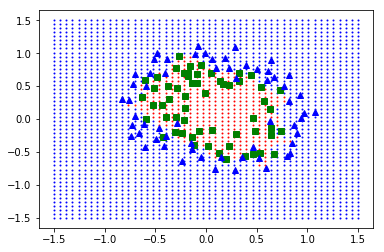

0.740698517169


In [13]:
f1_score = showVariant(data, 7, getKnnPredictioner(), True)
print(np.mean(f1_score))

1 fold, f1 score is 0.736842105263
2 fold, f1 score is 0.823529411765
3 fold, f1 score is 0.777777777778
4 fold, f1 score is 1.0
5 fold, f1 score is 0.842105263158
6 fold, f1 score is 0.8
7 fold, f1 score is 0.714285714286


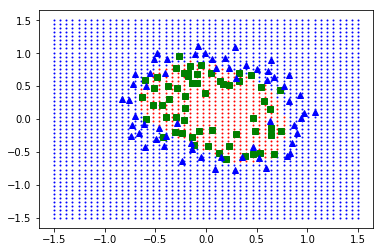

0.813505753178


In [14]:
f1_score = showVariant(data, 7, getSvmPredictioner(), True)
print(np.mean(f1_score))

In [15]:
def showConfusionMatrix(predictioner):          #predicted x real
    confM = [[0, 0], [0, 0]]
    predicted = predictioner(X, Y, X)
    for i in range(0, len(predicted)):
        if (Y[i] == 0):
            if (predicted[i] == 0):
                confM[0][0] += 1
            else:
                confM[1][0] += 1
        else:
            if (predicted[i] == 0):
                confM[0][1] += 1
            else:
                confM[1][1] += 1
    print('     |   0    |  1    |   - real ')
    print('     ------------------')
    print(' 0   |  ', confM[0][0], '  |  ', confM[0][1], '  |   ')
    print(' 1   |  ', confM[1][0], '  |  ', confM[1][1], ' |   ')

In [16]:
showConfusionMatrix(getSvmPredictioner())

     |   0    |  1    |   - real 
     ------------------
 0   |   49   |   6   |   
 1   |   11   |   52  |   


In [17]:
for i in range(0, 10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
x = np.array([1,2])
y = np.array([3,4])
np.dot(x.T, y)

11

In [19]:
alpha = np.array([1,2,3])
trainX = np.array([[1,2], [3,4], [5,6]])
trainY = np.array([1,0,1])
K =  lambda u, v : np.dot(u.T, v)

def __optimization_fun__(alpha, trainX, trainY):
        res = np.sum(alpha)
        # todo
        for i in range(0, len(alpha)):
            for j in range(0, len(alpha)):
                res -= 0.5 * alpha[i] * alpha[j] * trainY[i] * trainY[j] * K(trainX[i], trainX[j])
        return res
__optimization_fun__(alpha, trainX, trainY)

-322.0

In [20]:
x = np.array([[1,2],[3,4]])
np.apply_along_axis(lambda x : x[0] + x[1], 0, x)

array([4, 6])

In [21]:
X.shape

(118, 2)

In [22]:
# def f(x, dataX):
#     return np.apply_along_axis(lambda c : np.dot(x.T, c), 1, dataX)

def f (x, dataX):
    print(x)
    return np.apply_along_axis(lambda c : np.dot(x.T, c), 1, dataX)

x = np.array([[1,2],[3,4]])
z = np.apply_along_axis(lambda c : f(c, x), 1, x)
print(z)

np.apply_along_axis(lambda c : c * [1,2], 0, z)

[1 2]
[3 4]
[[ 5 11]
 [11 25]]


array([[ 5, 11],
       [22, 50]])

In [23]:
m = SVM_Classifier(1.)
m.fit(X, Y)
x_min, x_max = X.T[0].min() - .05, X.T[0].max() + .05
y_min, y_max = X.T[1].min() - .05, X.T[1].max() + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

test = np.c_[xx.ravel(), yy.ravel()]
a = np.array(m.predict(test)).reshape(xx.shape)
plt.figure(figsize=(10 ,10))
plt.contourf(xx, yy, a, alpha=.6)
plt.scatter(X[Y == 0].T[0], X[Y == 0].T[1])
plt.scatter(X[Y == 1].T[0], X[Y == 1].T[1])

Using default kernel


ValueError: operands could not be broadcast together with shapes (118,118) (2,1,1,2) 